In [1]:
import sys
sys.path.append('/home/gridsan/swagata/Atomistic-Adversarial-Attacks/')
sys.path.append('/home/gridsan/swagata/NeuralForceField/')
import robust as rb
import torch as ch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import copy
from nff.nn.tensorgrad import compute_grad
from torch.optim import Adam
from torch.utils.data.sampler import RandomSampler
from nff.data import Dataset, split_train_validation_test, collate_dicts, to_tensor
from nff.train import Trainer, get_trainer, get_model, load_model, loss, metrics, evaluate
from nff.train import hooks as nff_hook
from scipy import stats
from nff.io import NeuralFF, AtomsBatch,EnsembleNFF
import json

In [5]:
def E(x):
    return 5*x**4 - 20*x**2 + 1.5*x

In [6]:
def F(x):
    #x.requires_grad=True
    return -compute_grad(x, E(x))

In [7]:
def s(x):
    return x

In [8]:
class pos:
    def __init__(self, position):
        self.position = ch.Tensor(position)
        self.position.requires_grad=True
        #x.position.requres_grad=True
        #self.vel = ch.tensor([[0.0001*ch.rand(1)] for i in range(self.position.shape[0])])
        self.vel = ch.tensor([[0.0001*(i+1)] for i in range(self.position.shape[0])])
        #x.force=F(x.position)

In [9]:
def nve(x, dt):
    m = 20
    force_1 = F(x.position)
    x.position = x.position + x.vel*dt + 0.5*force_1*dt**2
    force_2 = F(x.position)
    x.vel = x.vel + 0.5*dt*(force_1 + force_2)
    #force = F(x.position)
    #x.vel = x.vel + 0.5*dt*force

In [10]:
def nve_bias(x, dt, Vbias_grad,bias=True):
    m = 1000
    st_1 = s(x.position)
    if bias==True:
        force_1 = F(x.position) + Vbias_grad
    else:
        force_1=F(x.position)
    x.vel=x.vel+0.5*dt*(force_1/m)
    x.position=x.position+x.vel*dt
    #x.position = x.position + x.vel*dt + 0.5*force_1*dt**2/m
    st_2 = s(x.position)
    if bias==True:
        force_2 = F(x.position) + Vbias_grad
    else:
        force_2=F(x.position)
    #force_2 = F(x.position) - Vbias_grad 
    x.vel = x.vel + 0.5*dt*(force_2/m)
#     force=F(x.position)
#     St=s(x.position)
#     force1=-biass.gradvalue(St.detach().numpy(),ss)
#     x.vel=x.vel+0.5*dt*(force+force1)
#     x.position=x.position+x.vel*dt
#     force=F(x.position)
#     St=s(x.position)
#     force1=-biass.gradvalue(St.detach().numpy(),ss)
#     x.vel=x.vel+0.5*dt*(force+force1)

In [11]:

def biasvalue(dt, s, st,tau,w,sigma):
    value = 0
    for i in range(st.shape[1]):
        value = value + tau*w*ch.exp(-0.5*(1/sigma**2)*(s - st[:,i].view(-1,s.shape[1]))**2)
    return value
def gradvalue(dt, s, st,tau,w,sigma):
    gradvalue = 0
    for i in range(st.shape[1]):
        gradvalue = gradvalue - tau*w*((s - st[:,i].view(-1,1))/sigma**2)*ch.exp(-0.5*(1/sigma**2)*(s - st[:,i].view(-1,s.shape[1]))**2)
    return -gradvalue # -compute_grad(s,biasvalue(dt,s,st))

In [12]:
def moveS(x,S,step,dt,zeta,temp,k,tau,w,sigma):
    t=step*dt
    dels=[]
    for j in range(x.position.shape[0]):
        dels.append(compute_grad(s(x.position),biasvalue(dt,s(x.position)[j].view(1,-1),S,tau,w,sigma).var()*ch.exp(-E(x.position[j].view(1,-1))/temp))[j])
    dels=ch.tensor(dels).view(-1,x.position.shape[1])
    delr=(1/compute_grad(x.position,s(x.position)))*dels
    x.position+=zeta*ch.exp(ch.tensor(-k*t))*delr

/home/gridsan/swagata/.conda/envs/nff/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/aten/src/ATen/native/RangeFactories.cpp:25.)
  """Entry point for launching an IPython kernel.


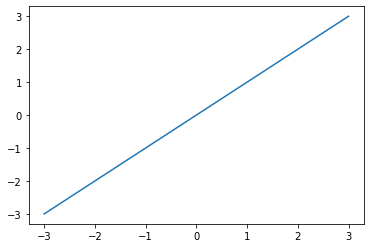

In [13]:
x = ch.linspace(-3, 3)
#print(len(x))
plt.plot(x, s(x))

In [14]:
x = ch.Tensor([2])
x.requires_grad = True
#print(x)

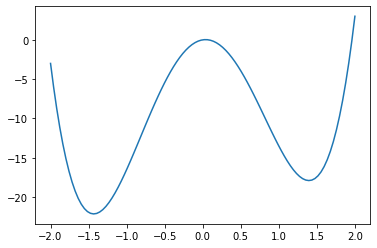

In [15]:
x = ch.linspace(-2, 2)
x.requres_grad = True
plt.plot(x, E(x))
#plt.plot(x.detach().numpy(),F(x).detach().numpy())

In [16]:
#Vbias1.biasvalue()

In [38]:
def run_md(x,ratio,zeta,temp,kappa,steps=10000,use_move=False,w=0.4,sigma=0.01,tau_ratio=10,dt=0.1,save_freq=500):
    S=ch.tensor([])
    Vb_grad=ch.zeros((x.position.shape[0],1))
    y=ch.linspace(-3, 3).view(-1,1)
    Bias=[]
    xx=[]
    for i in range(0, steps):
        if i%save_freq==0:
            xx.append(x.position.tolist())
        if i%tau_ratio==0:
            S=ch.cat((S,s(x.position)),dim=-1)
            Vb_grad = gradvalue(dt,s(x.position), S,tau_ratio*dt,w,sigma)
        nve_bias(x, dt, Vb_grad)
        if i%save_freq==0:
            Bias.append(ch.cat([biasvalue(dt,y, Ss.view(1,-1),tau_ratio*dt,w,sigma).detach() for Ss in S],dim=-1).tolist())
        if use_move==True:
            if i%(ratio*tau_ratio)==0:
                moveS(x,S,i,dt,zeta,temp,kappa,tau_ratio*dt,w,sigma)
    return S,Bias,xx
        

In [39]:
Ratio=[1,2,3,4,5]
Zeta=[0.1,1,2]
Temp=[0.2,2,20,200]
Kappa=[0,0.02,0.2,1]
CV_no,CV_yes,BiasV_no,BiasV_yes,XX_no,XX_yes=[],[],[],[],[],[]
x=pos([[1.2],[1.3],[1.2]])
props={}
S,Bias,xx=run_md(x,0,0,0,0,use_move=False)
props['S']=S.tolist()
props['Bias']=Bias
props['xx']=xx
with open('/home/gridsan/swagata/1Dmovehypermaters/1D_0_0_0_0.json','w') as handle:
    json.dump(props,handle)
for ratio in Ratio:
    for zeta in Zeta:
        for temp in Temp:
            for kappa in Kappa:
                props={}
                x=pos([[1.2],[1.3],[1.2]])
                S,Bias,xx=run_md(x,ratio,zeta,temp,kappa,use_move=True)
                props['S']=S.tolist()
                props['Bias']=Bias
                props['xx']=xx
                with open('/home/gridsan/swagata/1Dmovehypermaters/1D_%s_%s_%s_%s.json'%(ratio,zeta,temp,kappa),'w') as handle:
                    json.dump(props,handle)
                




In [220]:
%%time
#fig, ax = plt.subplots(20, 2, figsize = (10,50))
S=ch.tensor([])
Vb_grad=ch.zeros((x.position.shape[0],1))
y=ch.linspace(-3, 3).view(-1,1)
dt=0.1
Bias=[]
xx=[]
#print(x1.position)
Vb1, Vb2, Vb3, Vb1_grad, Vb2_grad, Vb3_grad = 0, 0, 0, 0, 0, 0
for i in range(0, 1000):
    #y = ch.linspace(-3, 3)
    #print(x1.position)
    if i%5 == 0:
        xx.append(x.position.detach().numpy())
     #   ax[k][0].plot(y, E(y))
    #    ax[k][0].scatter(x1.position.detach().numpy(), E(x1.position.detach().numpy()),color='purple')
     #   ax[k][0].scatter(x2.position.detach().numpy(), E(x2.position.detach().numpy()),color='red')
      #  ax[k][0].scatter(x3.position.detach().numpy(), E(x3.position.detach().numpy()),color='green')
    #print(x1.position)
    
    if i % 10 == 0:
        S=ch.cat((S,s(x.position)),dim=-1)
        Vb_grad = gradvalue(dt,s(x.position), S)
    nve_bias(x, dt, Vb_grad)
    #print(x1.position)
    #print(x3.position.detach().numpy())
#     nve(x1, 0.1)
#     nve(x2, 0.1)
#     nve(x3, 0.1)
    if i%5 == 0:
        Bias.append(ch.cat([biasvalue(dt,y, Ss.view(1,-1)).detach() for Ss in S],dim=-1))
        
    if (i+1)%50==0:
        moveS(x,S,i*dt)
        #ax[k][1].plot(y, biasvalue(dt,y, ch.tensor(s1)), color='purple')
        #ax[k][1].plot(y, biasvalue(dt,y, ch.tensor(s2)), color='red')
        #ax[k][1].plot(y, biasvalue(dt,y, ch.tensor(s3)), color='green')
        #k += 1
    #print(x1.position)
    
        #print(x1.position)

CPU times: user 1.89 s, sys: 76 µs, total: 1.89 s
Wall time: 1.89 s


tensor([[7.0055e-01],
        [9.9653e-20],
        [7.0154e-01]], grad_fn=<AddBackward0>)

In [170]:
Bias[0].shape

torch.Size([100, 3])

In [163]:
y.shape

torch.Size([100])

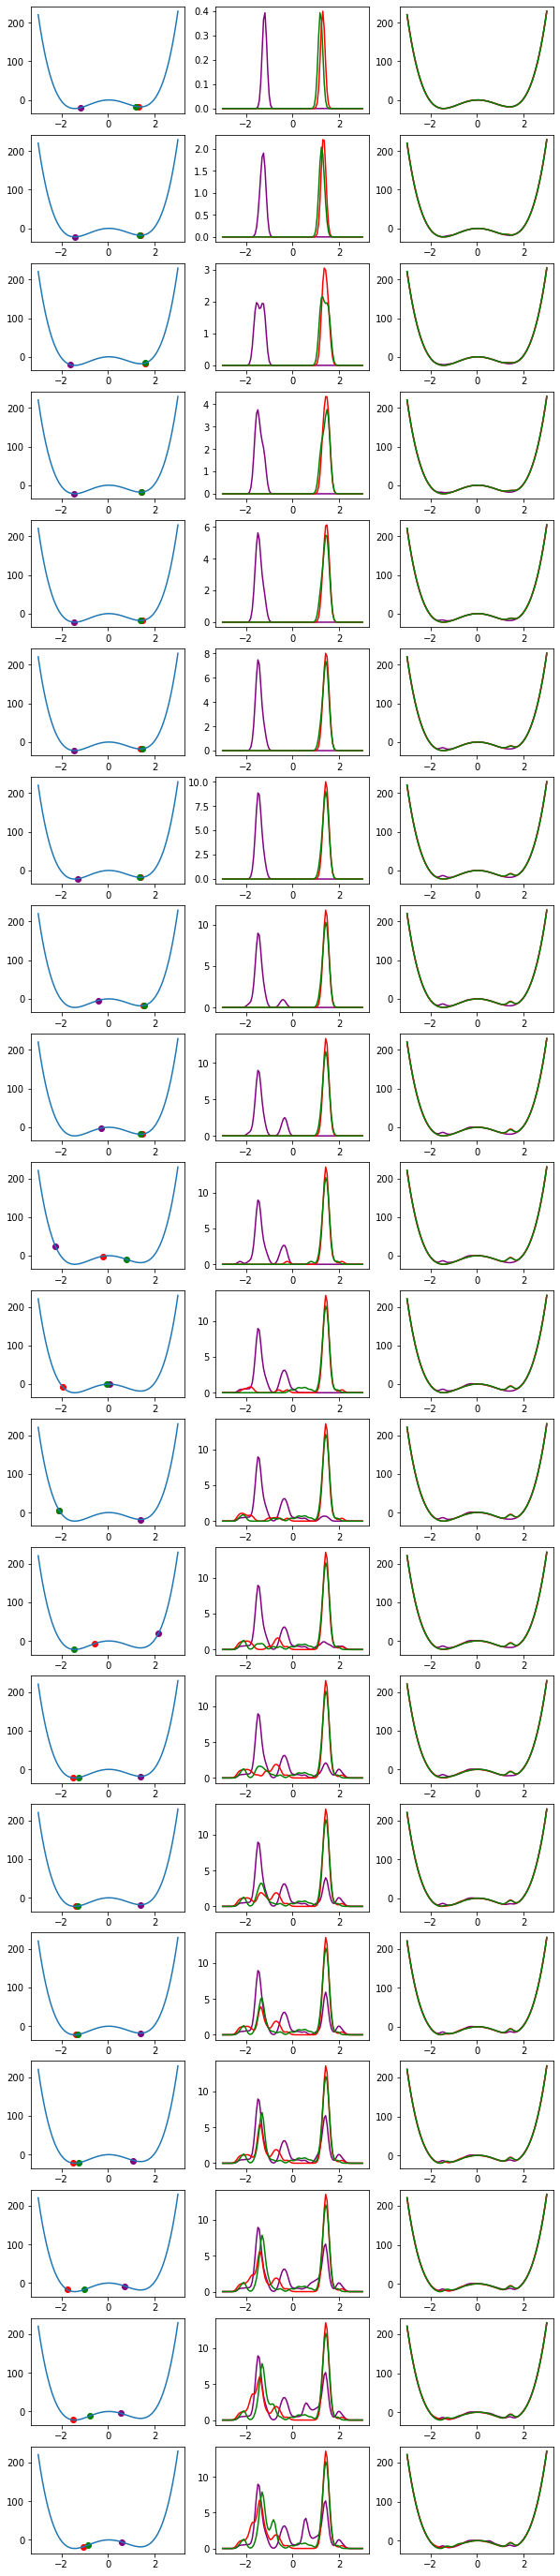

In [100]:
fig, ax = plt.subplots(20, 3, figsize = (10,50))
y = ch.linspace(-3, 3)
for k in range(20):
    ax[k][0].plot(y, E(y))
    ax[k][0].scatter(xx[k][0], E(xx[k][0]),color='purple')
    ax[k][0].scatter(xx[k][1], E(xx[k][1]),color='red')
    ax[k][0].scatter(xx[k][2], E(xx[k][2]),color='green')
    ax[k][1].plot(y, Bias[k][:,0], color='purple')
    ax[k][1].plot(y, Bias[k][:,1], color='red')
    ax[k][1].plot(y, Bias[k][:,2], color='green')
    ax[k][2].plot(y, E(y)+Bias[k][:,0], color='purple')
    ax[k][2].plot(y, E(y)+Bias[k][:,1], color='red')
    ax[k][2].plot(y, E(y)+Bias[k][:,2], color='green')

/home/gridsan/swagata/.conda/envs/nff/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


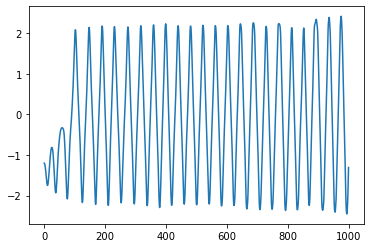

In [96]:
plt.plot(ch.tensor(S[0]))
#plt.plot(ch.tensor(S[1]))
#plt.plot(ch.tensor(S[2]))

/home/gridsan/swagata/.conda/envs/nff/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


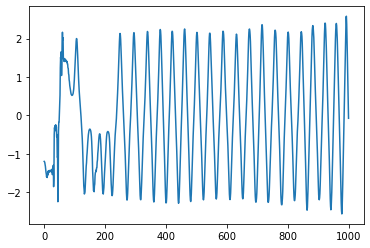

In [101]:
plt.plot(ch.tensor(S[0]))
#plt.plot(ch.tensor(S[1]))
#plt.plot(ch.tensor(S[2]))

In [192]:
xx

[array([[1.2],
        [1.3],
        [1.2]], dtype=float32),
 array([[1.2015412],
        [1.3009187],
        [1.2016408]], dtype=float32),
 array([[1.2060465],
        [1.3034613],
        [1.2062448]], dtype=float32),
 array([[1.2159789],
        [1.3092165],
        [1.2163244]], dtype=float32),
 array([[1.2337344],
        [1.3197225],
        [1.2343252]], dtype=float32),
 array([[1.2569308],
        [1.3367567],
        [1.2577734]], dtype=float32),
 array([[1.2831006],
        [1.3619827],
        [1.2841101]], dtype=float32),
 array([[1.3115162],
        [1.3913927],
        [1.3126407]], dtype=float32),
 array([[1.341388 ],
        [1.4208759],
        [1.3426099]], dtype=float32),
 array([[1.3722266],
        [1.4498506],
        [1.3735248]], dtype=float32),
 array([[1.403489 ],
        [1.4777095],
        [1.40484  ]], dtype=float32),
 array([[1.4345856],
        [1.5038372],
        [1.4359629]], dtype=float32),
 array([[1.4648889],
        [1.5276258],
        [1.46626

In [46]:
S

tensor([[ -1.2000,      nan,      nan,  ...,      nan,      nan,      nan],
        [  1.3000,  58.3607,  36.9963,  ...,      nan,      nan,      nan],
        [  1.2000,  31.6532, -66.1152,  ...,      nan,      nan,      nan]],
       grad_fn=<CatBackward>)

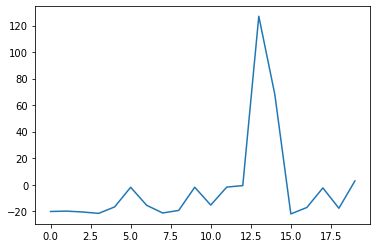

In [23]:
plt.plot(E(ch.tensor(xx)[:,0]))

In [14]:
1/ch.tensor([2,3])

tensor([0.5000, 0.3333])

In [207]:
s3

[array([1.2], dtype=float32),
 array([1.4837643], dtype=float32),
 array([1.9299291], dtype=float32),
 array([1.4166801], dtype=float32),
 array([1.1675051], dtype=float32),
 array([1.4331347], dtype=float32),
 array([1.939517], dtype=float32),
 array([1.4545012], dtype=float32),
 array([1.1778407], dtype=float32),
 array([1.4082235], dtype=float32),
 array([1.9143648], dtype=float32),
 array([1.51733], dtype=float32),
 array([1.2254994], dtype=float32),
 array([1.4051238], dtype=float32),
 array([1.8643571], dtype=float32),
 array([1.5855063], dtype=float32),
 array([1.2840692], dtype=float32),
 array([1.4017173], dtype=float32),
 array([1.8030965], dtype=float32),
 array([1.652684], dtype=float32),
 array([1.3368969], dtype=float32),
 array([1.384133], dtype=float32),
 array([1.7375774], dtype=float32),
 array([1.7199227], dtype=float32),
 array([1.3764842], dtype=float32),
 array([1.3482794], dtype=float32),
 array([1.669298], dtype=float32),
 array([1.7878994], dtype=float32),
 arr

In [698]:
#fig,ax=plt.subplots(5000,1,figsize=(5,150))
s1,s2,s3=[],[],[]
bias=ch.Tensor([0])
for i in range(0,5000):
    y=ch.linspace(-2.5,2.5)
    #ax[i].plot(y,E(y))
    #ax[i].scatter(x1.position.detach().numpy(),E(x1.position.detach().numpy()),color='yellow')
    #ax[i].scatter(x2.position.detach().numpy(),E(x2.position.detach().numpy()),color='red')
    #ax[i].scatter(x3.position.detach().numpy(),E(x3.position.detach().numpy()),color='green')
    ss=s(x1.position)
    bias=nve(x1,0.1,bias)
    
    #nve(x2,0.2)
    #nve(x3,0.2)
    #bias=moveS(x1,ss=ss,bias=bias,dt=0.1)
    print(x1.position,bias)
    s1.append(s(x1.position).detach().item())
    #s2.append(s(x2.position).detach().item())
    #s3.append(s(x3.position).detach().item())

tensor([-1.5886], grad_fn=<AddBackward0>) tensor([9999.9990], grad_fn=<AddBackward0>)
tensor([-1.5886], grad_fn=<AddBackward0>) tensor([20000.], grad_fn=<AddBackward0>)
tensor([-1.5886], grad_fn=<AddBackward0>) tensor([30000.], grad_fn=<AddBackward0>)
tensor([-1.5886], grad_fn=<AddBackward0>) tensor([40000.], grad_fn=<AddBackward0>)
tensor([-1.5886], grad_fn=<AddBackward0>) tensor([50000.], grad_fn=<AddBackward0>)
tensor([-1.5886], grad_fn=<AddBackward0>) tensor([60000.], grad_fn=<AddBackward0>)
tensor([-1.5886], grad_fn=<AddBackward0>) tensor([70000.], grad_fn=<AddBackward0>)
tensor([-1.5886], grad_fn=<AddBackward0>) tensor([80000.], grad_fn=<AddBackward0>)
tensor([-1.5886], grad_fn=<AddBackward0>) tensor([90000.], grad_fn=<AddBackward0>)
tensor([-1.5886], grad_fn=<AddBackward0>) tensor([100000.], grad_fn=<AddBackward0>)
tensor([-1.5886], grad_fn=<AddBackward0>) tensor([110000.], grad_fn=<AddBackward0>)
tensor([-1.5886], grad_fn=<AddBackward0>) tensor([120000.], grad_fn=<AddBackward0>

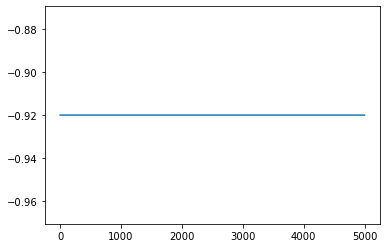

In [645]:
plt.plot(s1)
#plt.plot(s2)
#plt.plot(s3)

In [512]:
len(s1)

5000

In [532]:
s1[-1]

nan

In [607]:
def skewness(Y):
    Y=Y.view(-1,1)
    mean = ch.mean(Y)
    median=ch.median(Y)
    diffs = Y - mean
    var = ch.mean(ch.pow(diffs, 2.0))
    std = ch.pow(var, 0.5)
    zscores = diffs / std
    skews = ch.mean(ch.pow(zscores, 3.0))
    skews=(mean-median)/std
    return skews

In [514]:
s1

[0.9990867376327515,
 0.9987778663635254,
 0.9986577033996582,
 0.998902440071106,
 0.9991976022720337,
 0.9993999004364014,
 0.9995027780532837,
 0.9995046854019165,
 0.999405026435852,
 0.9992066621780396,
 0.9989131689071655,
 0.9986600875854492,
 0.9987673759460449,
 0.9990768432617188,
 0.9993233680725098,
 0.9994701147079468,
 0.9995166063308716,
 0.99946129322052,
 0.9993062019348145,
 0.9990508556365967,
 0.9987434148788452,
 0.9986699819564819,
 0.9989405870437622,
 0.9992281198501587,
 0.9994183778762817,
 0.9995092153549194,
 0.9994980096817017,
 0.9993855953216553,
 0.9991728067398071,
 0.9988692998886108,
 0.9986467361450195,
 0.998805046081543,
 0.9991163015365601,
 0.9993500709533691,
 0.9994832277297974,
 0.9995154142379761,
 0.9994455575942993,
 0.9992754459381104,
 0.9990048408508301,
 0.9987055063247681,
 0.9986940622329712,
 0.9989879131317139,
 0.9992637634277344,
 0.9994393587112427,
 0.9995146989822388,
 0.9994877576828003,
 0.999359130859375,
 0.9991294145584106

In [399]:
skewness(ch.tensor([-1.0,0,1.0]))

tensor(0.)

In [97]:
class bias:
    def __init__(self,s):
        self.tau=0.1
        self.w=1
        self.z=1
        self.s=s
        self.value=0
    def update_bias(self,st):
        self.value=self.value+self.tau*self.w*ch.exp(-0.5*(1/self.z**2)*(self.s-st)**2)
    

In [98]:
x=ch.linspace(-1,1)
x.requires_grad=True
sq=s(x[0])
Vbias=bias(sq)

In [99]:
Vbias.update_bias(-2)

In [100]:
Vbias.value

tensor(0.0607, grad_fn=<AddBackward0>)

In [101]:
compute_grad(x,Vbias.value)[0]

tensor(-0.0607, grad_fn=<SelectBackward>)

tensor([1.0000, 0.9996, 0.9984, 0.9963, 0.9935, 0.9898, 0.9854, 0.9802, 0.9742,
        0.9675, 0.9600, 0.9518, 0.9429, 0.9334, 0.9231, 0.9123, 0.9008, 0.8887,
        0.8761, 0.8630, 0.8494, 0.8353, 0.8208, 0.8058, 0.7905, 0.7749, 0.7589,
        0.7427, 0.7262, 0.7095, 0.6926, 0.6756, 0.6584, 0.6412, 0.6239, 0.6066,
        0.5892, 0.5719, 0.5547, 0.5375, 0.5205, 0.5036, 0.4868, 0.4702, 0.4538,
        0.4376, 0.4216, 0.4059, 0.3905, 0.3753, 0.3605, 0.3459, 0.3317, 0.3178,
        0.3042, 0.2910, 0.2781, 0.2655, 0.2534, 0.2416, 0.2301, 0.2190, 0.2083,
        0.1979, 0.1879, 0.1783, 0.1690, 0.1601, 0.1515, 0.1433, 0.1354, 0.1278,
        0.1205, 0.1136, 0.1070, 0.1007, 0.0947, 0.0889, 0.0835, 0.0783, 0.0734,
        0.0687, 0.0643, 0.0601, 0.0562, 0.0524, 0.0489, 0.0455, 0.0424, 0.0394,
        0.0367, 0.0341, 0.0316, 0.0293, 0.0272, 0.0251, 0.0233, 0.0215, 0.0198,
        0.0183], grad_fn=<AddBackward0>)

In [89]:
np.exp(-0.5)

0.6065306597126334